- Récupération du corpus --> import_corpus
- Séparation et récupération des tags, Patterns et Responses --> Extraction_data_X_Y
- Séparer les données en test et train --> Extraction_data_X_Y
- Data augmentation sur les patterns --> data_augmentation_syn
- Création d'un dictionnaire associant un chiffre à chaque tag --> dico_num_tag(y_texte)
- Création d'un dictionnaire associant un tag à une réponse --> Extraction_data_X_Y
- Vectoriser les patterns et voir leur gestion pour l'entrainement et la prédiction (prédiction normalement ok avec le 1er dictionnaire)
- Vectoriser les Patterns train
- Vectoriser les Patterns test de la même manière que ceux de train
- GridSearchCV pour voir les meilleurs paramètres
- Entrainement du modèle


##  Importation des librairies

In [1]:
import nltk
#from nltk.stem.lancaster import LancasterStemmer
#stemmer = LancasterStemmer()
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

In [2]:
# things we need for Tensorflow
import numpy as np
import keras
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pandas as pd
from nltk import word_tokenize

# Récupération du corpus 

In [3]:
# import our chat-bot intents file
import json

def import_corpus(jsonfile): #permet d'importer le corpus
    try:
        with open(jsonfile, encoding='utf-8') as json_data:
            intents = json.load(json_data)
        return intents

    except OSError as err:
        print("OS error: {0}".format(err))
    except ValueError:
        print("Your .json is wrong, look at https://jsonlint.com/")
    except BaseException as err:
        print(f"Unexpected {err=}, {type(err)=}")
        raise
        
corpus = import_corpus('intents.json')
#corpus

# Extraction_data_X_Y
- Séparation et récupération des tags, Patterns et Responses
- Séparer les données en test et train 
- Création d'un dictionnaire associant un tag à une réponse 
- Nettoyage des ponctuations

In [104]:
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

def extraction_data_X_y(jsonfile = None, testing = False, phrase : str = None): #permet d'obtenir les patterns (X_text) et les tags (y_text)
    
    ponctuation = [".", "?", "!", ",", ";", ":", "(",  ")", "[", "]", "«", "»", '"', "/", "}", "{", "'", "#","-","’"]

    if testing == False : #cas d'extraction des données du corpus
        corpus = import_corpus(jsonfile)
    
        X_texte = []
        y_texte = []
        Responses = []

        dico_tag_responses = {}

        #ponctuation = [".", "?", "!", ",", ";", ":", "(",  ")", "[", "]", "«", "»", '"', "/", "}", "{", "'", "#","-","’"]
        try :
            for doc in corpus['intents']: #'intents
                #print(doc['tag']) #obtenir chaque tag
                for p in doc['patterns']: #'patterns'
                    #print(p) #obtenir chaque phrase/patterns par tags 

                    for element in ponctuation:
                        p = p.replace(element," ")

                    #filtered_phrase = clean_text(p)
                    filtered_phrase = p




                    #X_texte.append(" ".join(filtered_phrase)) Bonne version avec stemming
                    X_texte.append(filtered_phrase)

                    y_texte.append(doc['tag']) 
                    #y_texte.append(doc['tag']) #on rajoute un 2e même tag car on double le dataset

                    Responses.append(doc['responses'])
                    dico_tag_responses[doc['tag']] = doc['responses']

            X_train, X_test, y_train, y_test = train_test_split(X_texte,y_texte,train_size=0.8)

            #print(f"\ndico_tag_responses : \n {dico_tag_responses}")
            return X_texte, y_texte, X_train, X_test, y_train, y_test, dico_tag_responses
        except:
            print("l'extraction des patterns et tags n'a pas fonctionnée, allez voir la fonction extraction data_X_y")
            
    else: #cas en utilisation pour récupérer la phrase
        #new_phrase = []
        
        for element in ponctuation:
            phrase = phrase.replace(element," ")
        
        new_phrase = phrase
        return new_phrase
        
X_text = []
y_text = []
X_texte, y_texte, X_train, X_test, y_train, y_test, dico_tag_responses = extraction_data_X_y('intents.json')
dico_tag_responses
#phrase_test = "Puis-je visiter l'isen?"
#extraction_data_X_y(None, True, phrase_test)

'Puis je visiter l isen '

In [ ]:
phrase_test = "Puis-je visiter l'isen?"

# dico_num_tag
- Création d'un dictionnaire associant un chiffre à chaque tag 

In [5]:
from sklearn.preprocessing import LabelBinarizer,LabelEncoder

def dico_num_tag(y_texte):
    enc1=LabelEncoder()
    enc1.fit(y_texte) #enc1.fit(X_train) --> supprimer les mots inconnues de la base de test --> enc1.transform(X_train) & enc1.transform(X_test)
    dicoLabel=enc1.transform(y_texte)
    tdico=zip(np.unique(dicoLabel),np.unique(y_texte))
    dic_dico={i:j for i,j in tdico} #pour associer les n° de tag à leur nom --> {0: 'Bourses', 1: 'Clubs_etudiants', 2: 'Handicap', 3: 'ISEN_logement' ...}
    print(dic_dico)
    return dic_dico

dico_numero_tag = dico_num_tag(y_texte)

{0: 'Bourses', 1: 'Clubs_etudiants', 2: 'Handicap', 3: 'ISEN_logement', 4: 'ISEN_restauration', 5: 'Job_ISEN', 6: 'La vie à Brest', 7: 'Nombre_etudiants_alumni_etudiants', 8: 'SHN', 9: 'Taux_insertion', 10: 'Yncrea', 11: 'bienvenue', 12: 'campus_ouest', 13: 'certifications', 14: 'cursus_isen', 15: 'raison_isen', 16: 'tarif_BIAST', 17: 'tarif_BIOST', 18: 'tarif_CENT', 19: 'tarif_CGSI', 20: 'tarif_CIR', 21: 'tarif_EST', 22: 'tarif_cycle_ingenieur', 23: 'visite_virtuelle_PO'}


# data_augmentation_syn
- Data augmentation sur les patterns 

In [6]:
from nltk.corpus import wordnet
from collections import OrderedDict
from deep_translator import GoogleTranslator

In [71]:
def find_synonyms(word):
    translated_word = GoogleTranslator(source='fr', target='en').translate(word)
    
    synonyms = []
    for synset in wordnet.synsets(translated_word):
        for syn in synset.lemma_names():
            synonyms.append(GoogleTranslator(source='en', target='fr').translate(syn))
            #print(syn,"sa traduction en français",GoogleTranslator(source='en', target='fr').translate(syn))
            
    # using this to drop duplicates while maintaining word order (closest synonyms comes first)
    synonyms_without_duplicates = list(OrderedDict.fromkeys(synonyms))
    return list(OrderedDict.fromkeys(synonyms)) #synonyms #synonyms_without_duplicates

In [72]:
from nltk import word_tokenize
def create_set_of_new_sentences(sentence, max_syn_per_word = 6, nbr_new_sentences = 1): #nbr_new_sentences est le nombre de "nouvelle" phrase crée par phrase, si =1 on va doubler le dataset par exemple
    try:
        new_sentences = []
        for word in nltk.word_tokenize(sentence):
            #print("\n")
            if len(word)<=3 : continue #les petits mots ont souvent des erreurs en synonymes
            for synonym in find_synonyms(word)[0:max_syn_per_word]:
                
                #print(synonym, word)
                synonym = synonym.replace('_', ' ') #restore space character
                new_sentence = sentence.replace(word,synonym)
                new_sentences.append(new_sentence)
        return new_sentences[1:nbr_new_sentences+1] #le premier correspond à la phrase initiale
    except:
        print("Peut être que votre phrase n'est pas dans la bonne langue (Français) ou que vous n'avez rien mis en entrée de la fonction")

In [73]:
def data_augmentation_syn(X_train,y_train, nbr_new_sentences = 1): #need X_train et y_train au format texte
    print(f"\nX_train {X_train} de taille {len(X_train)}")
    print(f"\ny_train {y_train} de taille {len(y_train)}")
    
    
    X_train_complete=[] #pour stocker les phrases complètes
    
    X_train_augmented = [] #[[0] for i in range(len(X_train)*(1+nbr_new_sentences))] #pour créer une liste de bonne taille
    y_train_augmented= [] #X_train_augmented #y_train_augmented sera de même taille que X_train_augmented
        
    #Pour avoir les phrases complètes (et pas des listes de mots pour une phrase) (ex: on veut [phrase1,phrase2,phrase3] et X_train est au départ sous format [[mot1_phrase1,mot2_phase1],[mot1_phrase2...
    for phrase in X_train :
        X_train_complete.append(phrase) 
    #print(f"X_train_complete {X_train_complete} et taille : {len(X_train_complete)}")
    
    
    i=0
    for phrase_initiale in X_train:
        print(f"\nphrase initiale : {phrase_initiale}")
        X_train_augmented.append(phrase_initiale)
        y_train_augmented.append(y_train[i])
        new_phrases=create_set_of_new_sentences(phrase_initiale, None, nbr_new_sentences)
        print(new_phrases)
        
        try :
            for new_phrase in new_phrases:
                print(f"NOUVELLE phrase : {new_phrase}")
                X_train_augmented.append(new_phrase)
                y_train_augmented.append(y_train[i])
            i+=1
        except : 
            print(f"{phrase_initiale} n'a pas pu avoir de phrases synonymes")
            
    print(f"\nX_train_augmented {X_train_augmented} de taille {len(X_train_augmented)}")
    print(f"\ny_train_augmented {y_train_augmented} de taille {len(y_train_augmented)}")
    return (X_train_augmented, y_train_augmented)
#X_train_augmented, y_train_augmented = data_augmentation_syn(X_texte,y_texte,nbr_new_sentences=2)


X_train ['Salut', 'Salut à tous', 'Bonjour à tous', 'Bonjour', 'Coucou', 'Comment ca va ', 'Comment tu vas ', 'je recherche de l aide', 'oyez oyez', 'hey', 'Pourquoi l isen  ', 'description isen', 'école d ingénieur généraliste', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'différence autres écoles ingénieurs', 'en quoi l isen est meilleur ', 'Pourquoi choisir l isen ', 'quelles sont les avantages offert par l isen ', 'qu offre l isen en termes d enseignement ', 'quelles performances peut on retrouvés à l isen', 'C est quoi l ISEN  ', 'cursus isen', 'années scolarité', 'En combien d années se déroule l ISEN  ', 'Qu est ce que l ISEN', 'C est quoi le cursus de l école', 'Combien d années d études post bac ', 'temps post bac', 'peut on intégrer l école après le bac', 'comment foncionne l ISEN', 'comment est on formé à l isen ', 'quelles sont les différentes possibilités suivant mon profil ', 'quels s

## sauvegarde des variables

In [192]:
X_train_augmented = ['Salut', 'salut', 'Salut à tous', 'salut à tous', 'Salut à tous', 'Bonjour à tous', 'Tiens à tous', 'salut à tous', 'Bonjour', 'Tiens', 'salut', 'Coucou', 'Tiens', 'salut', 'Comment ca va ', 'Comment tu vas ', 'je recherche de l aide', 'je enquête de l aide', 'je chercher de l aide', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'hey', 'Pourquoi l isen  ', 'pour cette raison l isen  ', 'description isen', 'description verbale isen', 'école d ingénieur généraliste', 'école d ingénieur généraliste', 'scolarité d ingénieur généraliste', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'C est quoi la déviation avec les autres écoles d ingénieurs  ', 'C est quoi la divergence avec les autres écoles d ingénieurs  ', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'Quelle est la déviation avec les autres écoles d ingénieurs  ', 'Quelle est la divergence avec les autres écoles d ingénieurs  ', 'différence autres écoles ingénieurs', 'déviation autres écoles ingénieurs', 'divergence autres écoles ingénieurs', 'en quoi l isen est meilleur ', 'en quoi l isen est parieur ', 'en quoi l isen est Pause ', 'Pourquoi choisir l isen ', 'pour cette raison choisir l isen ', 'Pourquoi choisir l isen ', 'quelles sont les avantages offert par l isen ', 'quelles ar les avantages offert par l isen ', 'quelles être les avantages offert par l isen ', 'qu offre l isen en termes d enseignement ', 'qu offre l isen en termes d enseignement ', 'qu fissure l isen en termes d enseignement ', 'quelles performances peut on retrouvés à l isen', 'quelles présentation publique peut on retrouvés à l isen', 'quelles exécution peut on retrouvés à l isen', 'C est quoi l ISEN  ', 'cursus isen', 'programme isen', "programme d'études isen", 'années scolarité', 'années scolarité', 'âge scolarité', 'En combien d années se déroule l ISEN  ', 'En combien d années se déroule l ISEN  ', 'En combien d âge se déroule l ISEN  ', 'Qu est ce que l ISEN', 'C est quoi le cursus de l école', 'C est quoi le programme de l école', "C est quoi le programme d'études de l école", 'Combien d années d études post bac ', 'Combien d années d études post bac ', 'Combien d âge d études post bac ', 'temps post bac', 'agrafe post bac', "temps d'horloge post bac", 'peut on intégrer l école après le bac', 'étain on intégrer l école après le bac', 'boîte de conserve on intégrer l école après le bac', 'comment foncionne l ISEN', 'comment œuvres l ISEN', 'comment installation industrielle l ISEN', 'comment est on formé à l isen ', 'comment est on forme lexicale à l isen ', 'comment est on signifiant à l isen ', 'quelles sont les différentes possibilités suivant mon profil ', 'quelles ar les différentes possibilités suivant mon profil ', 'quelles être les différentes possibilités suivant mon profil ', 'quels sont les enseignements à l isen ', 'quels ar les enseignements à l isen ', 'quels être les enseignements à l isen ', '204 écoles d ingénieurs', '204 école d ingénieurs', '204 scolarité d ingénieurs', 'ingénieur français', 'scientifique appliqué français', 'technologue français', 'C est quoi Yncréa Ouest  ', 'Combien y a t il d écoles dans l ouest ', 'Combien y a t il d école dans l ouest ', 'Combien y a t il d scolarité dans l ouest ', 'Quels sont les campus de l ISEN Ouest  ', 'Quels ar les campus de l ISEN Ouest  ', 'Quels être les campus de l ISEN Ouest  ', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et caribou', 'Où peut on étudier à l ISEN ', 'Où étain on étudier à l ISEN ', 'Où boîte de conserve on étudier à l ISEN ', 'quelles sont les centre de formation de l isen ', 'quelles ar les centre de formation de l isen ', 'quelles être les centre de formation de l isen ', 'quelle est la localisation de l ISEN ', 'quelle est la placement de l ISEN ', 'quelle est la localiser de l ISEN ', 'Quelles sont les certifications d Yncréa  ', 'Quelles ar les certifications d Yncréa  ', 'Quelles être les certifications d Yncréa  ', 'L isen est il sous contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'L isen est il en dessous de contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'L isen est il au dessous de contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'L isen est il sous contrat avec le MESR  ', 'L isen est il en dessous de contrat avec le MESR  ', 'L isen est il au dessous de contrat avec le MESR  ', 'gage de qualité de l isen', 'griller de qualité de l isen', 'assurance de qualité de l isen', 'MESR', 'L isen est il reconnu de quelconques manières ', 'L isen est il reconnaître de quelconques manières ', 'L isen est il connaître de quelconques manières ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu fissure l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Quel est le taux d insertion des jeunes diplômés  ', 'Quel est le charge per unit d insertion des jeunes diplômés  ', 'Quel est le rythme d insertion des jeunes diplômés  ', 'taux d insertion', 'charge per unit d insertion', 'rythme d insertion', 'Où sont embauchés les jeunes diplômés  ', 'Où ar embauchés les jeunes diplômés  ', 'Où être embauchés les jeunes diplômés  ', 'lieu d embauche', 'placement d embauche', 'localiser d embauche', 'Quels sont les lieux de travail après diplôme  ', 'Quels ar les lieux de travail après diplôme  ', 'Quels être les lieux de travail après diplôme  ', 'Trouve t on facilement du diplôme après l isen ', 'percée t on facilement du diplôme après l isen ', 'trouver t on facilement du diplôme après l isen ', 'Est on obligé de travailler sur paris après notre diplome ', 'Est on obligé de travailler sur Paris après notre diplome ', 'Est on obligé de travailler sur Ville de lumière après notre diplome ', 'Quelle est le taux d embauches après l ISEN ', 'Quelle est le charge per unit d embauches après l ISEN ', 'Quelle est le rythme d embauches après l ISEN ', 'C est quoi Yncrea  ', 'Qu est ce que Yncréa  ', 'Yncrea', 'Junia', 'Yncrea ouest', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Yncrea Nord', 'Yncrea syndicat', 'Yncrea due north', 'L isen fait elle est partie d un groupe ', 'L isen fais elle est partie d un groupe ', 'L isen avoir elle est partie d un groupe ', 'Pourquoi Yncrea ', 'pour cette raison Yncrea ', 'Quelle différences entre l isen et l Yncrea ', 'Quelle déviation entre l isen et l Yncrea ', 'Quelle divergence entre l isen et l Yncrea ', 'Combien y a t il d étudiants  ', 'Combien y a t il d instruit  ', 'Combien y a t il d savant  ', 'Combien y a t il d enseignants permanents ', 'Combien y a t il d instructeur permanents ', 'Combien y a t il d enseignants vague permanente ', 'Combien y a t il d alumnis  ', 'Combien y a t il d ancienne élève  ', 'Combien y a t il d alun  ', 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', 'nombre élèves', 'chiffre élèves', 'acte élèves', 'Quelles est le chiffre d étudiants à l isen ', 'Quelles est le figure d étudiants à l isen ', 'Quelles est le corps humain d étudiants à l isen ', 'Quelle est la population de l isen ', 'Quelle est la univers de l isen ', 'Quels sont les tarifs du cycle CGSI  ', 'Quels ar les tarifs du cycle CGSI  ', 'Quels être les tarifs du cycle CGSI  ', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'Quels sont les frais de scolarité du cycle CGSI  ', 'Quels ar les frais de scolarité du cycle CGSI  ', 'Quels être les frais de scolarité du cycle CGSI  ', 'Combien coûte les années 1 et 2 en CSI  ', 'Combien valeur monétaire les années 1 et 2 en CSI  ', 'Combien le prix les années 1 et 2 en CSI  ', 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'Combien valeur monétaire les années 1 et 2 classes préparatoires implantées', 'Combien le prix les années 1 et 2 classes préparatoires implantées', 'tarif CGSI', 'charge per unit CGSI', 'rythme CGSI', 'tarif CSI', 'charge per unit CSI', 'rythme CSI', 'Quelle est le montant d une année du cycle généraliste ', "Quelle est le somme d'argent d une année du cycle généraliste ", 'Quelle est le montant d une année du cycle généraliste ', 'une année du cycle généraliste  ça coute combien ', 'une classer du cycle généraliste  ça coute combien ', 'une année du cycle généraliste  ça coute combien ', 'Quels sont les tarifs du cycle CIR ', 'Quels ar les tarifs du cycle CIR ', 'Quels être les tarifs du cycle CIR ', 'tarif CIR', 'charge per unit CIR', 'rythme CIR', 'prix CIR', 'le prix CIR', 'Coût CIR', 'Quels sont les frais de scolarité du cycle CIR ', 'Quels ar les frais de scolarité du cycle CIR ', 'Quels être les frais de scolarité du cycle CIR ', 'Combien coûte les années 1 et 2 en CIR ', 'Combien valeur monétaire les années 1 et 2 en CIR ', 'Combien le prix les années 1 et 2 en CIR ', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien valeur monétaire les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien le prix les années 1 et 2 en Cycle Informatique et Réseaux', 'Quelle est le montant d une année du cycle informatique ', "Quelle est le somme d'argent d une année du cycle informatique ", 'Quelle est le montant d une année du cycle informatique ', 'une année du cycle informatique  ça coute combien ', 'une classer du cycle informatique  ça coute combien ', 'une année du cycle informatique  ça coute combien ', 'Quels sont les tarifs du cycle BIOST ', 'Quels ar les tarifs du cycle BIOST ', 'Quels être les tarifs du cycle BIOST ', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'prix BIOST', 'le prix BIOST', 'Coût BIOST', 'Quels sont les frais de scolarité du cycle BIOST ', 'Quels ar les frais de scolarité du cycle BIOST ', 'Quels être les frais de scolarité du cycle BIOST ', 'Combien coûte les années 1 et 2 en BIOST ', 'Combien valeur monétaire les années 1 et 2 en BIOST ', 'Combien le prix les années 1 et 2 en BIOST ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Quelle est le montant d une année du cycle biologique ', "Quelle est le somme d'argent d une année du cycle biologique ", 'Quelle est le montant d une année du cycle biologique ', 'une année du cycle biologique  ça coute combien ', 'une classer du cycle biologique  ça coute combien ', 'une année du cycle biologique  ça coute combien ', 'Quels sont les tarifs du cycle CENT  ', 'tarif CENT', 'Prix CENT', 'Quels sont les frais de scolarité du cycle CENT  ', 'Combien coûte les années 1 et 2 en CENT  ', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Combien le prix les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Quelle est le montant d une année du cycle economie ', "Quelle est le somme d'argent d une année du cycle economie ", 'Quelle est le montant d une année du cycle economie ', 'une année du cycle economie  ça coute combien ', 'une classer du cycle economie  ça coute combien ', 'une année du cycle economie  ça coute combien ', 'Quels sont les tarifs du cycle EST ', 'Quels ar les tarifs du cycle EST ', 'Quels être les tarifs du cycle EST ', 'tarif EST', 'charge per unit EST', 'rythme EST', 'prix EST', 'le prix EST', 'Coût EST', 'Quels sont les frais de scolarité du cycle EST ', 'Quels ar les frais de scolarité du cycle EST ', 'Quels être les frais de scolarité du cycle EST ', 'Combien coûte les années 1 et 2 en EST ', 'Combien valeur monétaire les années 1 et 2 en EST ', 'Combien le prix les années 1 et 2 en EST ', 'Combien coûte les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Quelle est le montant d une année du cycle environnement ', "Quelle est le somme d'argent d une année du cycle environnement ", 'Quelle est le montant d une année du cycle environnement ', 'une année du cycle environnement  ça coute combien ', 'une classer du cycle environnement  ça coute combien ', 'une année du cycle environnement  ça coute combien ', 'Quels sont les tarifs du cycle BIAST ', 'Quels ar les tarifs du cycle BIAST ', 'Quels être les tarifs du cycle BIAST ', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'Quels sont les frais de scolarité du cycle BIAST ', 'Quels ar les frais de scolarité du cycle BIAST ', 'Quels être les frais de scolarité du cycle BIAST ', 'Combien coûte les années 1 et 2 en BIAST ', 'Combien valeur monétaire les années 1 et 2 en BIAST ', 'Combien le prix les années 1 et 2 en BIAST ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Quelle est le montant d une année du cycle agronomie ', "Quelle est le somme d'argent d une année du cycle agronomie ", 'Quelle est le montant d une année du cycle agronomie ', 'une année du cycle agronomie  ça coute combien ', 'une classer du cycle agronomie  ça coute combien ', 'une année du cycle agronomie  ça coute combien ', 'Quels sont les tarifs du cycle ingénieur ', 'Quels ar les tarifs du cycle ingénieur ', 'Quels être les tarifs du cycle ingénieur ', 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Quel est le tarif du cycle ingénieur ', 'Quel est le charge per unit du cycle ingénieur ', 'Quel est le rythme du cycle ingénieur ', 'prix des années 3  4 et 5', 'le prix des années 3  4 et 5', 'Coût des années 3  4 et 5', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', 'Quels sont les frais de scolarité en années 3  4 et 5  ', 'Quels ar les frais de scolarité en années 3  4 et 5  ', 'Quels être les frais de scolarité en années 3  4 et 5  ', 'Combien coûte les années 3 à 5  ', 'Combien valeur monétaire les années 3 à 5  ', 'Combien le prix les années 3 à 5  ', 'Quelle est le montant d une année du cycle supérieur ', "Quelle est le somme d'argent d une année du cycle supérieur ", 'Quelle est le montant d une année du cycle supérieur ', 'une année du cycle supérieur  ça coute combien ', 'une classer du cycle supérieur  ça coute combien ', 'une année du cycle supérieur  ça coute combien ', 'Comment puis je payer l école  ', 'Comment alors je payer l école  ', 'Comment et donc je payer l école  ', 'Comment puis je payer la formation ', 'Comment alors je payer la formation ', 'Comment et donc je payer la formation ', 'Comment puis je payer l ISEN ', 'Comment alors je payer l ISEN ', 'Comment et donc je payer l ISEN ', 'Comment financer mes études   ', 'Comment financer mes enquête   ', 'Comment financer mes étude   ', 'bourses d  excellence', 'érudition d  excellence', 'apprentissage d  excellence', 'Quelles sont les bourses disponibles ', 'Quelles ar les bourses disponibles ', 'Quelles être les bourses disponibles ', 'ERASMUS est il disponible pour payer l isen', 'Desiderius Erasmus est il disponible pour payer l isen', 'Gerhard Gerhards est il disponible pour payer l isen', 'l accès aux bourses est elle possible en intégrant l isen ', 'l accéder aux bourses est elle possible en intégrant l isen ', 'l accession aux bourses est elle possible en intégrant l isen ', 'L isen dispose t elle de bourses d études ', 'L isen HA t elle de bourses d études ', 'L isen avoir t elle de bourses d études ', 'une bourse est elle décrochable selon nos perfomances académiques ', 'une bourse est elle oblitérable selon nos perfomances académiques ', 'une bourse est elle décrochable selon nos performance académiques ', 'Sportif de Haut Niveau', 'acrobatique de Haut Niveau', 'gymnastique de Haut Niveau', 'Peut on être SHN ', 'étain on être SHN ', 'boîte de conserve on être SHN ', 'Peut on être en Sport de Haut Niveau ', 'étain on être en Sport de Haut Niveau ', 'boîte de conserve on être en Sport de Haut Niveau ', 'L isen est elle adaptée pour les Sportifs ', 'L isen est elle accommoder pour les Sportifs ', 'L isen est elle régler pour les Sportifs ', 'L isen est elle adaptée pour le Sport de compétition ', 'L isen est elle accommoder pour le Sport de compétition ', 'L isen est elle régler pour le Sport de compétition ', 'Peut on être accompagner en tant que sportif ', 'étain on être accompagner en tant que sportif ', 'boîte de conserve on être accompagner en tant que sportif ', 'Puis je continuer mon activité sportive de haut niveau en intégrant l isen ', 'alors je continuer mon activité sportive de haut niveau en intégrant l isen ', 'et donc je continuer mon activité sportive de haut niveau en intégrant l isen ', 'Un aménagement des horaires est il possible si je suis sportif de haut niveau ', 'Un aménagement des ordre du jour est il possible si je suis sportif de haut niveau ', 'Un aménagement des rôle est il possible si je suis sportif de haut niveau ', 'Y a t il un Internat ', 'Quels sont les logements autour de l école', 'Quels ar les logements autour de l école', 'Quels être les logements autour de l école', 'Quelles sont les résidences étudiantes ', 'Quelles ar les résidences étudiantes ', 'Quelles être les résidences étudiantes ', 'Pourrais je avoir des informations sur les habitations autour ', 'Pourrais je avoir des Info sur les habitations autour ', 'Pourrais je avoir des Les données sur les habitations autour ', 'où loger autour de l école ', 'où Sir Oliver Lodge autour de l école ', 'où Sir Oliver Joseph Lodge autour de l école ', 'Comment trouver un logement à proximité de l isen ', 'Comment trouver un hébergement à proximité de l isen ', 'Comment trouver un logements de vie à proximité de l isen ', 'Où habiter si j intègre l isen ', 'Où habiter si j déségréger l isen ', 'Où habiter si j mélanger l isen ', 'Des conseils sur où se loger en intégrant l ISEN ', 'Des conseils sur où se Loge en intégrant l ISEN ', 'Des conseils sur où se Sir Oliver Lodge en intégrant l ISEN ', 'Quels sont les moyens de restauration ', 'Quels ar les moyens de restauration ', 'Quels être les moyens de restauration ', 'Comment puis je manger ', 'Comment alors je manger ', 'Comment et donc je manger ', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', 'Y a t il une cafeteria ', 'Puis je manger au Super u ', 'alors je manger au Super u ', 'et donc je manger au Super u ', 'Comment se restaurer quand on étudie à l isen ', 'Comment se reconstruire quand on étudie à l isen ', 'Comment se régénérer quand on étudie à l isen ', 'l isen possède t elle une cafétaria ', 'l isen groupe comitatus t elle une cafétaria ', 'l isen posséder t elle une cafétaria ', 'L isen est elle loin des restaurants universitaires ', 'L isen est elle ALIR des restaurants universitaires ', 'L isen est elle Anciennes forces armées des restaurants universitaires ', 'Puis je visiter l isen', 'alors je visiter l isen', 'et donc je visiter l isen', 'Comment peut on découvrir le bâtiment', 'Comment étain on découvrir le bâtiment', 'Comment boîte de conserve on découvrir le bâtiment', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', 'Peut on visiter l isen', 'étain on visiter l isen', 'boîte de conserve on visiter l isen', 'peut on découvrir l isen lors de portes ouvertes ', 'étain on découvrir l isen lors de portes ouvertes ', 'boîte de conserve on découvrir l isen lors de portes ouvertes ', 'y a t il une possibilité de rencontrer les professeurs et visiter l établissement ', 'y a t il une hypothèse de rencontrer les professeurs et visiter l établissement ', 'y a t il une théorie de rencontrer les professeurs et visiter l établissement ', 'L école est elle adaptée aux Handicaps', 'L école est elle adaptée aux Handicaps', 'L scolarité est elle adaptée aux Handicaps', 'Peut on avoir un tiers temps', 'étain on avoir un tiers temps', 'boîte de conserve on avoir un tiers temps', 'A t on des aménagements handicaps', 'A t on des conforts de créature handicaps', 'A t on des Agréments handicaps', 'Peut on y venir avec un fauteuil roulant', 'étain on y venir avec un fauteuil roulant', 'boîte de conserve on y venir avec un fauteuil roulant', 'Le batiment est il accessible pour les personnes à mobilité réduite', 'Le édifice est il accessible pour les personnes à mobilité réduite', 'Le construction est il accessible pour les personnes à mobilité réduite', 'Je suis en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je Un m en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je numéro atomique 95 en situation de handicap  l isen a t elle les capacités de me recevoir ', 'L isen est elle habilité a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'L isen est elle passe a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'L isen est elle dégager a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'Quels sont les clubs isen', 'Quels ar les clubs isen', 'Quels être les clubs isen', 'Quelles sont les associations étudiantes', 'Quelles ar les associations étudiantes', 'Quelles être les associations étudiantes', 'Peut on en savoir plus sur la vie étudiante', 'étain on en savoir plus sur la vie étudiante', 'boîte de conserve on en savoir plus sur la vie étudiante', 'Quel est le club digitaldesign', 'Quel est le ball club digitaldesign', 'Quel est le club digitaldesign', 'Quel est le club 4Ltrophy', 'Quel est le ball club 4Ltrophy', 'Quel est le club 4Ltrophy', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'BDA', 'Quelle est la vie étudiante au sein de l ISEN ', 'Quelle est la vie instruit au sein de l ISEN ', 'Quelle est la vie savant au sein de l ISEN ', 'L isen possède t elle des associations pour développer la vie étudiante ', 'L isen groupe comitatus t elle des associations pour développer la vie étudiante ', 'L isen posséder t elle des associations pour développer la vie étudiante ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu fissure l isen en dehors des enseignements obligatoires ', 'Comment est la ville de Brest', 'Comment est la les citadins de Brest', 'Comment est la citadins de Brest', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'Comment est la vie en finistère', 'Pleut il vraiment à Brest', 'pleuvoir il vraiment à Brest', 'il pleut il vraiment à Brest', 'Quelles sont les avantages de vivre à Brest ', 'Quelles ar les avantages de vivre à Brest ', 'Quelles être les avantages de vivre à Brest ', 'A quoi m attendre de Brest ', 'A quoi m anticiper de Brest ', 'A quoi m interroger de Brest ', 'La vie brestoise est t elle compliqué ou chère ', 'La vie brestoise est t elle embarrasser ou chère ', 'La vie brestoise est t elle affiner ou chère ', 'Quelles sont les Offres d emploi', 'Quelles ar les Offres d emploi', 'Quelles être les Offres d emploi', 'Peut on travailler à Yncrea', 'étain on travailler à Yncrea', 'boîte de conserve on travailler à Yncrea', 'Peut on Travailler à l ISEN', 'étain on Travailler à l ISEN', 'boîte de conserve on Travailler à l ISEN', 'Peut t on prendre un emploi étudiant au sein de l isen ', 'étain t on prendre un emploi étudiant au sein de l isen ', 'boîte de conserve t on prendre un emploi étudiant au sein de l isen ', 'L isen propose t elle des emplois rémunérés aux étudiants ', 'L isen suggérer t elle des emplois rémunérés aux étudiants ', 'L isen conseiller t elle des emplois rémunérés aux étudiants ']
y_train_augmented = ['bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest']

# nettoyage
- Enlève les mots inutiles des phrases (programme adapté pour X_train ET X_test)

In [109]:
from nltk.corpus import stopwords

from nltk.stem.snowball import FrenchStemmer
import string


def clean_text(phrase): #fait du french stemming et du stop words sur une phrase
    """
    test = True indique que la phrase fait parti du dataset de test --> donc on rajoute aux stop_words TOUS les mots du dataset train
    """
    #print(f"----------------------Début clean_text ------------------")
    try:
        
        
        stemmer = FrenchStemmer()
        
        alphabet = list(string.ascii_lowercase)
        une_lettre = ["é", "â", "ê", "î", "ô", "û", "è", "ç", "ä", "ë", "ï", "ö", "ü", "ÿ"]
        for lettre in une_lettre:
            alphabet.append(lettre)
            
        stop_words=stopwords.words("French")
        for element in alphabet:
            stop_words.append(element)
        
        
        
        filtered_sentence=[]

        #enlever les stop words
        for mot in nltk.word_tokenize((phrase.lower())):
                    
                    #print(mot)
                    if mot not in stop_words:
                        filtered_sentence.append(mot)
        #print(filtered_sentence)

        #stemming en français
     #  print("dans cas données train")

        stemmed = [stemmer.stem(i) for i in filtered_sentence] #stemmer.stem(i) bonne version avec stemming 
        return stemmed
    
    except:
        print("stemming et stop_words n'ont pas fonctionnés")
    
test=clean_text("")
test
phrase_test = clean_text("Puis je visiter l isen")
phrase_test

['puis', 'visit', 'isen']

In [108]:
def nettoyage(X_to_clean):
    X_cleaned=[]
    try :
        for phrase in X_to_clean:
             #   print(f"phrase: {phrase}")
            X_cleaned.append(clean_text(phrase))
            #print(f"X_cleaned : {X_cleaned}")
            
        return X_cleaned
    except : 
        print(f"nettoyage n'a pas marché sur {X_to_clean}")
X_train_augmented_clean = nettoyage(X_train_augmented)
X_test_clean = nettoyage(X_test)



[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [77]:
#len(y_train_augmented)

In [78]:
#print(X_test_clean)

In [79]:
#X = [['mot1','mot2','mot3'], ['mot4', 'mot5', 'mot6', 'mot7'], ['mot8', 'mot9', 'mot10']]
#print(collage(X))

# on veut ['mot1 mot2 mot3', 'mot4 mot5 mot6 mot7', mot8 mot9 mot10']

In [80]:
print(len(X_train_augmented_clean))
print(len(X_test_clean))
def clean_multiple(X,y): #pour enlever les phrases qui se répètent après le data_augmentation_syn
    new_X = [] 
    new_y = []

    i=0
    for phrase in X : 
        if phrase not in new_X: 
            new_X.append(phrase) 
            #print("\n",i)
            new_y.append(y[i])
            #print(phrase,"----",y[i]," ------- i = ",i)
        i+=1
    return new_X, new_y

X_train_augmented_clean, y_train_augmented = clean_multiple(X_train_augmented_clean, y_train_augmented)
#X_train_augmented_clean

570
42


In [81]:
def collage(X_to_merge):
    #print(f"taille debut : {len(X_to_merge)}")
    new_X = []
    phrase=""
    for phrase in X_to_merge :
        #print("phrase : ", phrase)
        new_X.append(" ".join(phrase))
        """for mot in phrase : 
            print('mot:',mot)
            new_X.append(" ".join(phrase))
           """ 
    #print(f"taille finale: {len(new_X)}")
    return new_X
        
print("TRAIN")
X_train_augmented_clean = collage(X_train_augmented_clean)
    
print("\nTEST")
X_test_clean = collage(X_test_clean)
#X_train_augmented_clean[:10]

TRAIN

TEST


In [82]:
#X_train_augmented_clean_test

In [83]:
len(X_train_augmented_clean)

509

In [84]:
len(y_train_augmented)

509

In [85]:
len(X_test_clean)

42

In [86]:
len(y_test)

42

# Vectorizer
- Vectoriser les patterns et voir leur gestion pour l'entrainement et la prédiction (prédiction normalement ok avec le 1er dictionnaire)
- Vectoriser les Patterns train
- Vectoriser les Patterns test de la même manière que ceux de train

In [87]:
from sklearn.preprocessing import OneHotEncoder

#X_train = ["mot1 mot2 mot3","mot4","mot1 mot3"]
#X_test = ["mot1 mot2 mot3 mot5"]

def vectorizer(X_to_vect, train = True, encodeur = None):
    try :
        if train: #cas où on est sur les données d'entrainements : on doit donc créer notre encodeur
            
            enc1=CountVectorizer()
            #enc1=LabelEncoder()
            #enc1=LabelBinarizer()
            #enc1=TfidfVectorizer()
            #enc1=OneHotEncoder(handle_unknown='ignore')


            enc1.fit(X_to_vect) #enc1.fit(X_train) --> supprimer les mots inconnues de la base de test --> enc1.transform(X_train) & enc1.transform(X_test)
            X_train_vec = enc1.transform(X_to_vect)
            X_train_vec = X_train_vec.toarray()
            
            return X_train_vec, enc1
        
        else: #cas où on est avec les données tests, on doit donc récupérer l'encodeur utilisé sur les données d'entrainement pour tranform dessus
            X_test_vec = encodeur.transform(X_to_vect)
            
            X_test_vec = X_test_vec.toarray()
            
            return X_test_vec
            
    except :
        print("la fonction vectorizer n'a pas fonctionnée")

#X_train_vec_test, encodeur = vectorizer(X_train) 
#X_test_vec_test = vectorizer(X_test, False, encodeur)

X_train_vec, encodeur_X = vectorizer(X_train_augmented_clean) 
X_test_vec = vectorizer(X_test_clean, False, encodeur_X)

y_train_vec, encodeur_y = vectorizer(y_train_augmented) 
y_test_vec = vectorizer(y_test, False, encodeur_y)

In [66]:
#print(y_train_augmented[10:20])
#for i in range (10,20
print(list(zip(X_train_augmented_clean[30:40],y_train_augmented[30:40])))

[('divergent autr écol ingénieur', 'raison_isen'), ('quoi isen meilleur', 'raison_isen'), ('quoi isen parieur', 'raison_isen'), ('quoi isen paus', 'raison_isen'), ('pourquoi chois isen', 'raison_isen'), ('cet raison chois isen', 'raison_isen'), ('quel avantag offert isen', 'raison_isen'), ('quel ar avantag offert isen', 'raison_isen'), ('quel être avantag offert isen', 'raison_isen'), ('offre isen term enseign', 'raison_isen')]


In [30]:
X_train_test = ["mot1 mot2 mot3","mot4","mot1 mot3"]
X_test_test = ["mot1 mot2 mot3 mot5"]

X_train_vec_test, encodeur_X_test = vectorizer(X_train_test) 
X_test_vec_test = vectorizer(X_test_test, False, encodeur_X_test)

print(X_train_vec_test)

print("\n",X_test_vec_test)
#print(X_train_vec_test)
#print(X_test_vec_test)

[[1 1 1 0]
 [0 0 0 1]
 [1 0 1 0]]

 [[1 1 1 0]]


In [40]:
#encodeur_X.get_feature_names()

## Dictionnaire numero tag
- celui au dessus ne fonctionne pas car le np.unique ne conserve pas l'ordre initial

In [88]:
y_train_vec.argmax(axis=1)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 15, 15, 15,
       15, 15, 15, 15, 15

In [89]:
def dictionnaire_numero_tag(y_train_vec, y_train_augmented):

    dictionnaire_test = {}
    list_y_num = y_train_vec.argmax(axis=1)
    for i in range (len(list_y_num)):
        dictionnaire_test [list_y_num[i]] = y_train_augmented[i]
    return dictionnaire_test
num_tag = dictionnaire_numero_tag(y_train_vec, y_train_augmented)
num_tag

{0: 'bienvenue',
 12: 'raison_isen',
 6: 'cursus_isen',
 3: 'campus_ouest',
 4: 'certifications',
 21: 'Taux_insertion',
 24: 'Yncrea',
 11: 'Nombre_etudiants_alumni_etudiants',
 17: 'tarif_CGSI',
 18: 'tarif_CIR',
 15: 'tarif_BIOST',
 16: 'tarif_CENT',
 20: 'tarif_EST',
 14: 'tarif_BIAST',
 19: 'tarif_cycle_ingenieur',
 1: 'Bourses',
 13: 'SHN',
 8: 'ISEN_logement',
 9: 'ISEN_restauration',
 23: 'visite_virtuelle_PO',
 7: 'Handicap',
 5: 'Clubs_etudiants',
 2: 'La vie à Brest'}

In [90]:
np.unique(y_train_vec.argmax(axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24], dtype=int64)

# GridSearchCV
- pour voir les meilleurs paramètres
- Entrainement du modèle

## Random Forest

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
#from sklearn.model_selection import RandomizedSearchCV

start = time.time()

param_grid= {'n_estimators':np.arange(1,30),
            'max_leaf_nodes':np.arange(1,20)}

grid_random_forest = GridSearchCV(RandomForestClassifier(random_state=123, oob_score = False),param_grid, cv=3) 
#random_state=123 permet de fixer l'aléatoire, plus pratique pour nos tests
#max_features=33 vient d'un GridSearchCV avec max_features, n_estimators et max_leaf_nodes (trop long de refaire les 3)
#oob_score=True permet d'afficher certains résultats ensuite
grid_random_forest.fit(X_train_vec, y_train_vec)

end = time.time()
print(end - start)

print(f"les meilleurs paramètres sont : {grid_random_forest.best_params_} avec un score de {grid_random_forest.best_score_}")
#permet de bloquer les NOMBREUX warnings avec oob_score
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

#67.20339608192444
#les meilleurs paramètres sont : {'max_leaf_nodes': 17, 'n_estimators': 3} avec un score de 0.005917159763313609

62.142986536026
les meilleurs paramètres sont : {'max_leaf_nodes': 17, 'n_estimators': 3} avec un score de 0.005917159763313609


## SGDClassifier
Linear SVM OU logistic regression  : https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/

In [93]:
from sklearn.linear_model import SGDClassifier

In [94]:
start = time.time()
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid_sgd_classifier= GridSearchCV(clf, param_grid=params, cv=10)


grid_sgd_classifier.fit(X_train_vec, y_train_vec.argmax(axis=1))

end = time.time()
print(end - start)

print(f"les meilleurs paramètres sont : {grid_sgd_classifier.best_params_} avec un score de {grid_sgd_classifier.best_score_}")

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

#264.8882083892822
#les meilleurs paramètres sont : {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'} avec un score de 0.8267450980392157

247.38291120529175
les meilleurs paramètres sont : {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'} avec un score de 0.8209411764705884


In [97]:
model_sgd = grid_sgd_classifier.best_estimator_

In [ ]:
#clf = SGDClassifier(loss="log", penalty="l2")
#clf = SGDClassifier(loss="hinge", penalty="l2")
#clf.fit(X_train_vec, y_train_vec.argmax(axis=1))

In [ ]:
#print('Accuracy: {:.2f}'.format(accuracy_score(y_test_vec.argmax(axis=1), clf.predict(X_test_vec))))

#print(f"y_test_vec: \n{y_test_vec.argmax(axis=1)} au format {y_test_vec.argmax(axis=1).shape}")
#print(f"\nX_test_vec: \n{X_test_vec} au format {X_test_vec.shape}")
#clf.predict(X_train_vec)#.argmax(axis=1)


#ac = accuracy_score(y_train_vec.argmax(axis=1), clf.predict(X_train_vec))
#print(f"accuracy score : {ac}")

# Evaluation du modele
- matrice de confusion
- oob_score
- accuracy

## Random Forest

Matrice de confusion sur les predictions de données d'entrainement


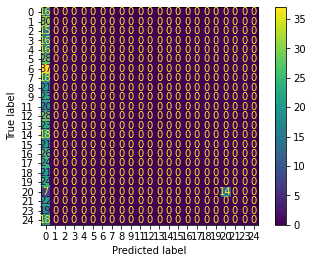

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec.argmax(axis=1), grid_random_forest.predict(X_train_vec).argmax(axis=1))

Matrice de confusion sur les predictions de données d'entrainement


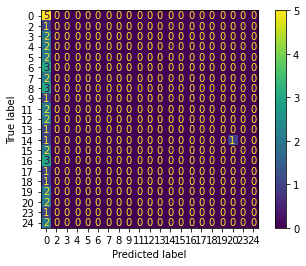

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_vec.argmax(axis=1), grid_random_forest.predict(X_test_vec).argmax(axis=1))

## SGDClassifier

Matrice de confusion sur les predictions de données d'entrainement


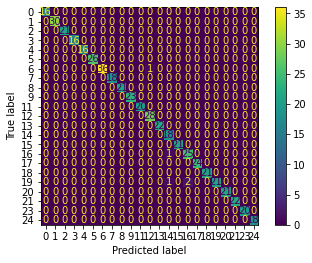

In [98]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec.argmax(axis=1), model_sgd.predict(X_train_vec))
#print(model_sgd.score(X_test_vec, y_test_vec.argmax(axis=1)))

Matrice de confusion sur les predictions de données d'entrainement


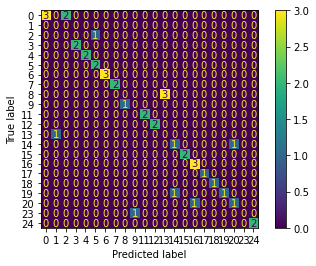

In [99]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_vec.argmax(axis=1), model_sgd.predict(X_test_vec))

# Predict
- prend en entrée une phrase et le modèle entrainé
- met en sortie la réponse prédite (utilisation des dictionnaires crée au début)
- Prend en compte la proba de prédiction et propose une reformulation ou les tag les plus proches si proba < à un certain seuil

## exemple jeu de données iris

In [20]:
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# Load the Iris dataset
iris_X, iris_y = datasets.load_iris(return_X_y=True)
# Split Iris dataset into train/test sets randomly
np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-10]]
iris_y_train = iris_y[indices[:-10]]
iris_X_test = iris_X[indices[-10:]]
iris_y_test = iris_y[indices[-10:]]
# Instantiate and fit a KNeighbors classifier
knn = KNeighborsClassifier()
knn.fit(iris_X_train, iris_y_train)

KNeighborsClassifier()

In [21]:
predictions = knn.predict(iris_X_test)
print(len(iris_X_test))
print(predictions)

10
[1 2 1 0 0 0 2 1 2 0]


In [22]:
proba = knn.predict_proba(iris_X_test)
print(proba)

[[0.  1.  0. ]
 [0.  0.4 0.6]
 [0.  1.  0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 [0.  0.  1. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [1.  0.  0. ]]


## fonction prediction classification phrase

In [289]:
#dico_tag_responses

In [236]:
print(dico_numero_tag)

{0: 'Bourses', 1: 'Clubs_etudiants', 2: 'Handicap', 3: 'ISEN_logement', 4: 'ISEN_restauration', 5: 'Job_ISEN', 6: 'La vie à Brest', 7: 'Nombre_etudiants_alumni_etudiants', 8: 'SHN', 9: 'Taux_insertion', 10: 'Yncrea', 11: 'bienvenue', 12: 'campus_ouest', 13: 'certifications', 14: 'cursus_isen', 15: 'raison_isen', 16: 'tarif_BIAST', 17: 'tarif_BIOST', 18: 'tarif_CENT', 19: 'tarif_CGSI', 20: 'tarif_CIR', 21: 'tarif_EST', 22: 'tarif_cycle_ingenieur', 23: 'visite_virtuelle_PO'}


In [291]:
num_tag

{0: 'bienvenue',
 12: 'raison_isen',
 6: 'cursus_isen',
 3: 'campus_ouest',
 4: 'certifications',
 21: 'Taux_insertion',
 24: 'Yncrea',
 11: 'Nombre_etudiants_alumni_etudiants',
 17: 'tarif_CGSI',
 18: 'tarif_CIR',
 15: 'tarif_BIOST',
 16: 'tarif_CENT',
 20: 'tarif_EST',
 14: 'tarif_BIAST',
 19: 'tarif_cycle_ingenieur',
 1: 'Bourses',
 13: 'SHN',
 8: 'ISEN_logement',
 9: 'ISEN_restauration',
 23: 'visite_virtuelle_PO',
 7: 'Handicap',
 5: 'Clubs_etudiants',
 2: 'La vie à Brest'}

In [113]:
def predict(phrase : str, trained_model, encodeurX, dic_num_tag, dico_tag_responses):
    print(phrase)
    
    phrase = extraction_data_X_y(None, True, phrase) #enlever les -, les ' etc
    print(f"après extraction_data_X_y {phrase}")
    
    phrase_clean = nettoyage([phrase])
    print(f"après nettoyage {phrase_clean}")
    
    phrase_clean = collage(phrase_clean)
    print(f"après collage {phrase_clean}")
    
    phrase_vec = vectorizer(phrase_clean, False, encodeurX)
    print(f"après vectorizer {phrase_vec}")

    
    prediction = trained_model.predict(phrase_vec)#.argmax(axis=1)
    
    tag_predi = dic_num_tag[prediction[0]]
    print(tag_predi,prediction)
    reponse = dico_tag_responses[tag_predi]
    #print(reponse)
    
    return reponse

phrase_test = "Puis-je visiter l'isen?" #X_train[0]
predict(phrase_test, grid_sgd_classifier, encodeur_X, num_tag, dico_tag_responses)

Puis-je visiter l'isen?
après extraction_data_X_y Puis je visiter l isen 
après nettoyage [['puis', 'visit', 'isen']]
après collage ['puis visit isen']
après vectorizer [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]]
ISEN_restauration [9]


['L’ISEN se trouve en bordure du principal campus étudiant de Brest. De fait, les services dédiés aux étudiants se trouvent à proximité, à 300 m de l’école, deux restaurants universitaires accueillent les étudiants, midi et soir. De plus, un foyer, géré par les étudiants, accueille les élèves le midi et le soir et propose des plats chauds.\nPlus de renseignements sur le site du Crous Bretagne.']

In [57]:
#np.argwhere(X_train_vec[0]==1)
X_train_vec[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

---
**erreurs de dictionnaire de classification :** 
- "tag testé" : résultat




- "ISEN_logement" : SHN (13) (mauvaise classification)
- "bienvenue" : bienvenue [0]
- "raison_isen" : raison_isen [12]
- "campus_ouest" : campus_ouest [3]
- "certifications" : certifications [4]
- "Taux_insertion" : Taux_insertion [21]
- "Yncrea" : Yncrea [24]
- "Nombre_etudiants_alumni_etudiants" : Nombre_etudiants_alumni_etudiants [11]
- "tarif_CGSI" : tarif_CGSI [17]
- "tarif_CIR" : tarif_CIR [18]
- Tous les autres tarifs des prepa bonne classification
- "tarif_cycle_ingenieur" : tarif_BIAST [14] (mauvaise classification)
- "Bourses" : tarif_cycle_ingenieur [19] (mauvaise classification)
- "SHN" : Bourses [1] (mauvaise classification)
- "ISEN_logement" : SHN [13] (mauvaise classification)
- "ISEN_restauration" : ISEN_logement [8] (mauvaise classification)
- "visite_virtuelle_PO" : ISEN_restauration [9] (mauvaise classification)
- "Handicap" : visite_virtuelle_PO [23] (mauvaise classification)
- "Clubs_etudiants" : Handicap [7] (mauvaise classification)
- "La vie à Brest" : Clubs_etudiants [5] (mauvaise classification)
- "Job_ISEN" : La vie à Brest [2] (mauvaise classification)

In [349]:
phrase_illona = "résidence étudiante"

In [352]:
predict(phrase_illona, grid_sgd_classifier, encodeur_X, num_tag, dico_tag_responses)

taille debut : 1
taille finale: 1
SHN [13]


['L’ISEN Yncréa Ouest est un « établissement d’accueil sport de haut niveau ».\nCe label émis par le rectorat et la DRJSCS(Direction régionale de la jeunesse, des sports et de la cohésion sociale de Bretagne) reconnait et certifie l’ engagement et les actions menées pour l’ accueil des sportifs de haut niveau par le campus de Brest.\nLes établissements labellisés garantissent un aménagement du parcours de formation des sportifs de haut niveau afin de leur permettre de mener à bien leur double projet scolaire et sportif.En ce qui concerne le sport de manière générale, chaque jeudi après - midi, les étudiants sont théoriquement libérés afin de pratiquer des activités sportives.\nOrganisées par le Bureau des Sports de l’ école, de multiples équipes participent aux championnats universitaires en football, basket, hand, volley et rugby.']

# Sources

- Voici la liste de tous les paramètres reglables du random forest : 

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start']) 

Pour plus d'infos, allez voir ces sites :
https://ichi.pro/fr/guide-du-debutant-sur-le-reglage-des-hyperparametres-de-foret-aleatoire-77596161963319
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot

Machine learnia avec les types d'encoder (onehotencoder etc...)